In [1]:
import json
from pprint import pprint
import pandas as pd

def load_mongo_collection(filename):
    collection = []
    with open(filename) as fd:
        while True:
            line = fd.readline()
            if line:
                data = json.loads(line)
                collection.append(data)
            else:
                break
    
    return collection

attack_log = load_mongo_collection("./csic_attack_log.json") + load_mongo_collection("./modsec_attack_log.json")
normal_log = load_mongo_collection("./csic_normal_log.json") + load_mongo_collection("./my_normal_log.json")

pprint(len(attack_log))
pprint(attack_log[:5])

23764
[{'_id': {'$oid': '5ecbcc60140ff600050519e2'},
  'matched_rules': [{'id': 920273,
                     'matched_value': 'Matched "Operator `ValidateByteRange\' '
                                      'with parameter '
                                      "`38,44-46,48-58,61,65-90,95,97-122' "
                                      "against variable `REQUEST_BODY' (Value: "
                                      '`modo=entrar&login=arro&pwd=CarMinAR%3C%21--%23include+file%3D%22archivo_secreto%22+--%3E&remember=on '
                                      "(10 characters omitted)' )",
                     'msg': 'Invalid character in request (outside of very '
                            'strict set)'},
                    {'id': 941180,
                     'matched_value': 'Matched "Operator `Pm\' with parameter '
                                      '`document.cookie document.write '
                                      '.parentnode .innerhtml window.location '
                  

In [2]:
# collect all available rules
all_rules = set()
for item in attack_log:
    [all_rules.add(x["id"]) for x in item["matched_rules"]]

for item in normal_log:
    [all_rules.add(x["id"]) for x in item["matched_rules"]]

display(len(all_rules), list(all_rules)[:10])

156

[944130,
 943110,
 942100,
 942101,
 921110,
 942110,
 921120,
 942120,
 921130,
 941100]

In [3]:
from sklearn.model_selection import train_test_split

def transform_log_item(item):
    global all_rules
    transformed_data = {
        "request_method": item.get("request_method"),
        # "uri": item.get("uri")
    }

    for rule_id in all_rules:
        transformed_data[str(rule_id)] = 0

    for rule_id in map(lambda x: x["id"], item.get("matched_rules")):
        transformed_data[str(rule_id)] = 1

    return transformed_data

cleaned_attack_log = [transform_log_item(x) for x in attack_log]
cleaned_normal_log = [transform_log_item(x) for x in normal_log]

X = pd.DataFrame(cleaned_attack_log + cleaned_normal_log)
# convert request_method using one hot encoding
temp = pd.get_dummies(X["request_method"], prefix="request_method")
X = pd.concat([X, temp], axis=1).drop(["request_method"], axis=1)

Y = pd.Series([1]*len(cleaned_attack_log) + [0]*len(cleaned_normal_log))

# x_attack_log = cleaned_attack_log
# y_attack_log = [1] * len(cleaned_attack_log)
# x_attack_train, x_attack_test, y_attack_train, y_attack_test = train_test_split(x_attack_log, y_attack_log, test_size=0.33, random_state=42)

# x_normal_log = cleaned_normal_log
# y_normal_log = [0] * len(cleaned_normal_log)
# x_normal_train, x_normal_test, y_normal_train, y_normal_test = train_test_split(x_normal_log, y_normal_log, test_size=0.33, random_state=42)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=2)

# X_train = pd.DataFrame(x_attack_train + x_normal_train)
# Y_train = pd.Series(y_attack_train + y_normal_train)
# X_test = pd.DataFrame(x_attack_test + x_normal_test)
# Y_test = pd.Series(y_attack_test + y_normal_test)

display("X train")
display(X_train.head(), X_train.shape)

display("Y train")
display(Y_train.head())

display("X test")
display(X_test.head(), X_test.shape)

display("Y test")
display(Y_test.head())

'X train'

,944130,943110,942100,942101,921110,942110,921120,942120,921130,941100,...,920500,951240,944100,944110,944120,request_method_GET,request_method_HEAD,request_method_OPTIONS,request_method_POST,request_method_PUT
209533,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
90593,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
130578,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
218722,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
42400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


(182792, 161)

'Y train'

209533    0
90593     0
130578    0
218722    0
42400     0
dtype: int64

'X test'

,944130,943110,942100,942101,921110,942110,921120,942120,921130,941100,...,920500,951240,944100,944110,944120,request_method_GET,request_method_HEAD,request_method_OPTIONS,request_method_POST,request_method_PUT
246172,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
108389,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
49738,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6141,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
53730,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


(90033, 161)

'Y test'

246172    0
108389    0
49738     0
6141      1
53730     0
dtype: int64

In [4]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion="entropy", max_depth=15)

clf.fit(X_train, Y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=15)

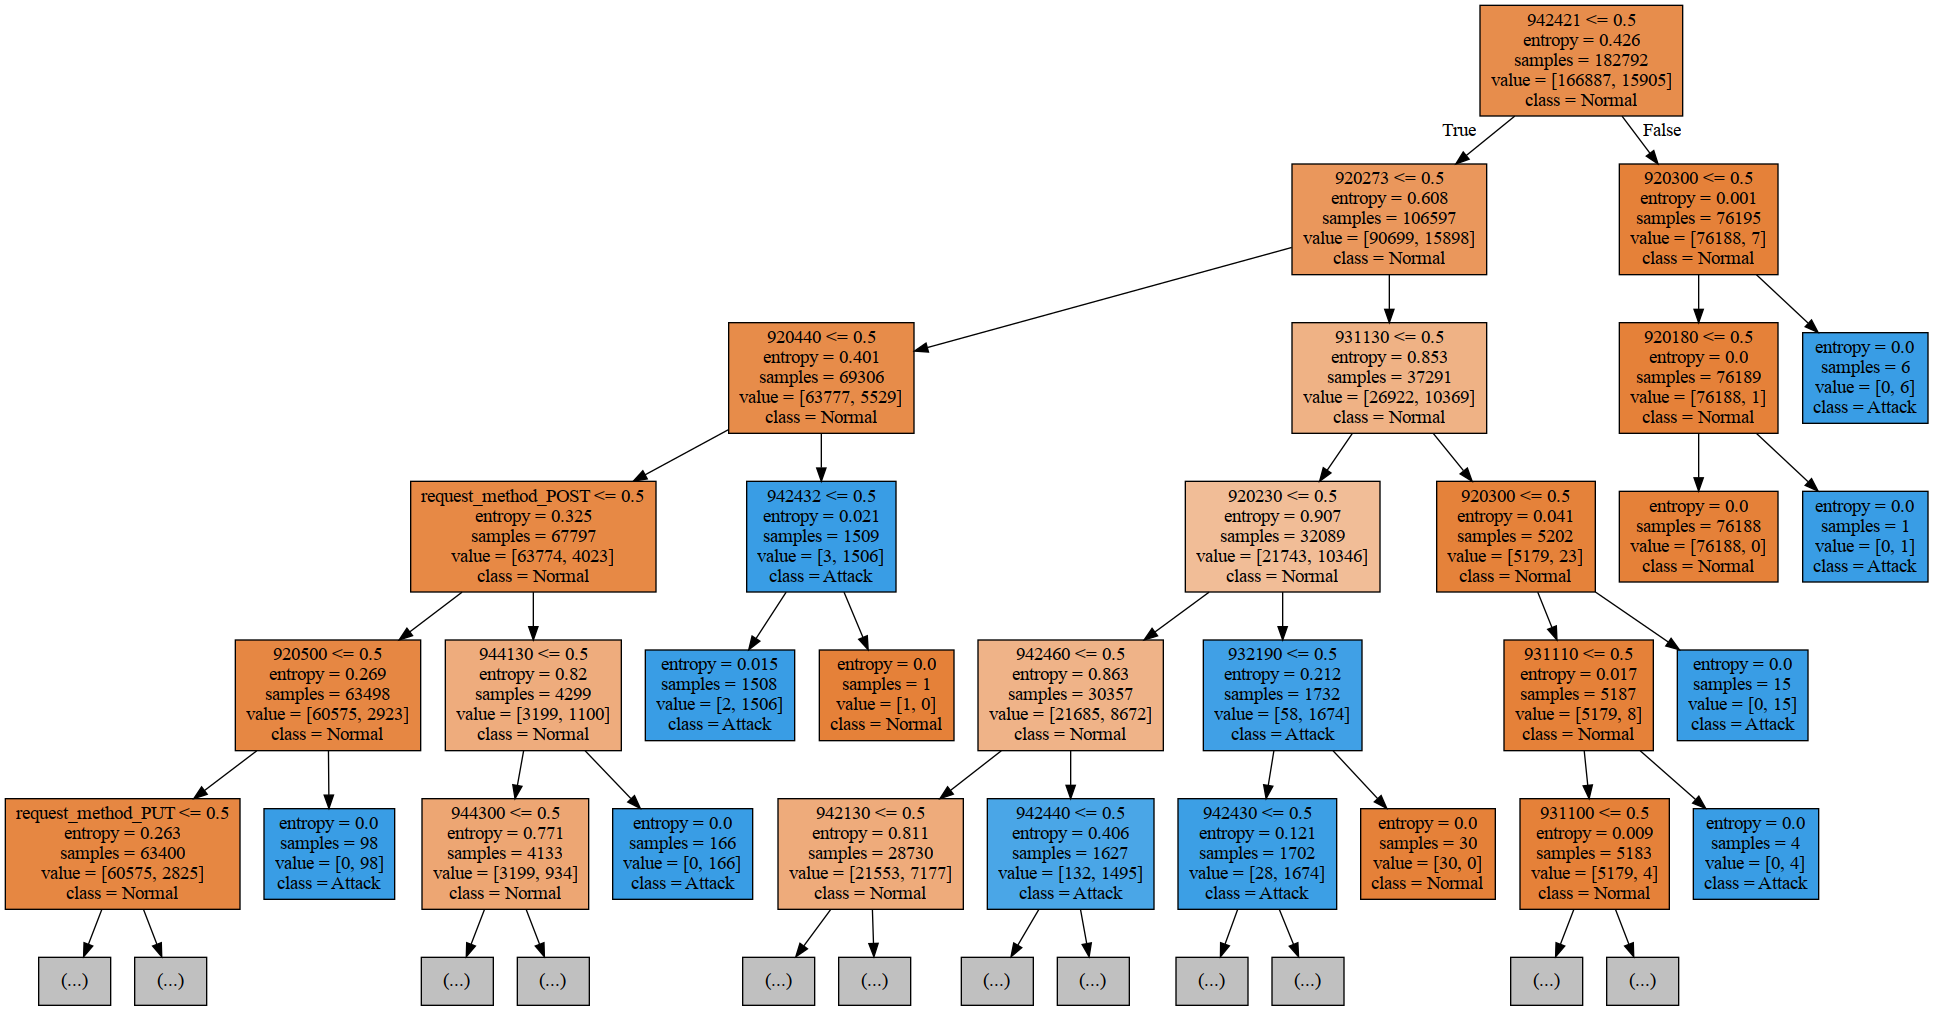

In [5]:
from sklearn.tree import export_graphviz
from subprocess import check_call
from PIL import Image

with open("./decision_tree.dot", "w") as fd:
    export_graphviz(clf, out_file=fd, feature_names=X_train.columns, class_names=('Normal', 'Attack'), max_depth=5, filled=True)

check_call("dot -Tpng decision_tree.dot -o decision_tree.png", shell=True)

img = Image.open("./decision_tree.png")
display(img)

In [6]:
train_score = clf.score(X_train, Y_train)
test_score = clf.score(X_test, Y_test)

display(train_score, test_score)

0.9519727340365005

0.951528883853698

In [7]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(criterion="entropy", max_depth=15)

forest_clf.fit(X_train, Y_train)
forest_train_score =  forest_clf.score(X_train, Y_train)
forest_test_score = forest_clf.score(X_test, Y_test)

display(forest_train_score, forest_test_score)

0.9492045603746334

0.9488409805293615